# Stain Normalization of IDC Pathology Images with TIAToolbox

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/03_stain_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

H&E (Hematoxylin and Eosin) stained slides from different laboratories, scanners, or staining protocols can have significantly different color appearances. This color variation can confuse computational pathology algorithms that were trained on data with a particular staining style.

**Stain normalization** transforms the color appearance of a source image to match a target image, reducing batch effects while preserving tissue structure.

This notebook demonstrates how to:
- Download slides from two different IDC collections to show staining variation
- Apply three normalization methods: **Macenko**, **Reinhard**, and **Vahadane**
- Compare the results side-by-side

**No GPU required** for this notebook.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.tools.stainnorm import (
    MacenkoNormalizer,
    ReinhardNormalizer,
    VahadaneNormalizer,
)

  check_for_updates()



## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [ ]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 16:57:31 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.8 GB available
GPU:  Not available


## 1. Select Slides from Two Different Collections

To demonstrate stain variation, we'll select slides from two different collections that image the same tissue type (lung) but were scanned at different sites with potentially different staining protocols.

In [ ]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")

# Find small 20x slides from two different lung cancer collections
collections = ['cptac_luad', 'tcga_luad']
slides = {}

for collection in collections:
    result = idc_client.sql_query(f"""
        SELECT
            i.SeriesInstanceUID,
            i.PatientID,
            i.collection_id,
            ROUND(i.series_size_MB, 1) as size_mb,
            s.ObjectiveLensPower,
            s.min_PixelSpacing_2sf as pixel_spacing_mm
        FROM sm_index s
        JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
        WHERE i.collection_id = '{collection}'
            AND s.ObjectiveLensPower >= 20
        ORDER BY i.series_size_MB ASC
        LIMIT 1
    """)
    slides[collection] = result.iloc[0]
    print(f"{collection}: {result.iloc[0]['PatientID']}, {result.iloc[0]['size_mb']} MB")

cptac_luad: C3L-03262, 21.8 MB
tcga_luad: TCGA-55-8207, 11.4 MB


In [ ]:
# Download both slides
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

readers = {}
for collection, slide_info in slides.items():
    series_uid = slide_info['SeriesInstanceUID']
    idc_client.download_from_selection(
        downloadDir=download_dir,
        seriesInstanceUID=[series_uid],
        dirTemplate='%SeriesInstanceUID'
    )
    slide_path = os.path.join(download_dir, series_uid)
    reader = WSIReader.open(slide_path)

    # DICOMWSIReader may not populate objective_power or mpp
    info = reader.info
    if info.objective_power is None:
        info.objective_power = float(slide_info['ObjectiveLensPower'])
    if info.mpp is None:
        pixel_spacing_um = float(slide_info['pixel_spacing_mm']) * 1000
        info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

    readers[collection] = reader
    print(f"Opened {collection}: {type(reader).__name__}")

Opened cptac_luad: DICOMWSIReader


Opened tcga_luad: DICOMWSIReader


## 2. Extract Tissue Patches and Observe Stain Variation

Let's extract patches from tissue-rich areas of both slides and compare their color appearance.

In [ ]:
def find_tissue_patch(reader, patch_size=512):
    """Find a tissue-rich patch from the slide at native resolution."""
    thumb = reader.slide_thumbnail(resolution=1.25, units="power")
    gray = np.mean(thumb, axis=2)
    tissue_mask = gray < 200

    coords = np.argwhere(tissue_mask)
    if len(coords) == 0:
        center_y, center_x = thumb.shape[0] // 2, thumb.shape[1] // 2
    else:
        center_y, center_x = coords.mean(axis=0).astype(int)

    slide_w, slide_h = reader.info.slide_dimensions
    baseline_x = int(center_x * slide_w / thumb.shape[1])
    baseline_y = int(center_y * slide_h / thumb.shape[0])

    # Read at native resolution (reliable with DICOMWSIReader)
    loc_x = max(0, baseline_x - patch_size // 2)
    loc_y = max(0, baseline_y - patch_size // 2)

    patch = reader.read_rect(
        location=(loc_x, loc_y),
        size=(patch_size, patch_size),
        resolution=reader.info.objective_power,
        units="power",
        coord_space="resolution",
    )
    return patch


# Extract patches from both slides
patch_target = find_tissue_patch(readers['cptac_luad'])
patch_source = find_tissue_patch(readers['tcga_luad'])

# Show side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(patch_target)
axes[0].set_title("CPTAC-LUAD (Target)", fontsize=13)
axes[0].axis('off')

axes[1].imshow(patch_source)
axes[1].set_title("TCGA-LUAD (Source)", fontsize=13)
axes[1].axis('off')

plt.suptitle("Stain variation between collections", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Apply Stain Normalization Methods

TIAToolbox provides three stain normalization methods:

- **Reinhard**: Simple color transfer in LAB color space. Fast but may not preserve structure well.
- **Macenko**: Decomposes stain vectors using SVD. Better structure preservation.
- **Vahadane**: Sparse non-negative matrix factorization for stain separation. Best structure preservation but slowest.

The workflow is:
1. **Fit** the normalizer to a target image (the desired color appearance)
2. **Transform** the source image(s) to match the target's staining

In [ ]:
normalizers = {
    "Reinhard": ReinhardNormalizer(),
    "Macenko": MacenkoNormalizer(),
    "Vahadane": VahadaneNormalizer(),
}

# Fit each normalizer to the target patch
for name, normalizer in normalizers.items():
    normalizer.fit(patch_target)
    print(f"{name} normalizer fitted to target.")

Reinhard normalizer fitted to target.
Macenko normalizer fitted to target.
Vahadane normalizer fitted to target.


In [ ]:
# Transform the source patch with each method
normalized = {}
for name, normalizer in normalizers.items():
    normalized[name] = normalizer.transform(patch_source.copy())
    print(f"{name} normalization complete.")

Reinhard normalization complete.
Macenko normalization complete.
Vahadane normalization complete.


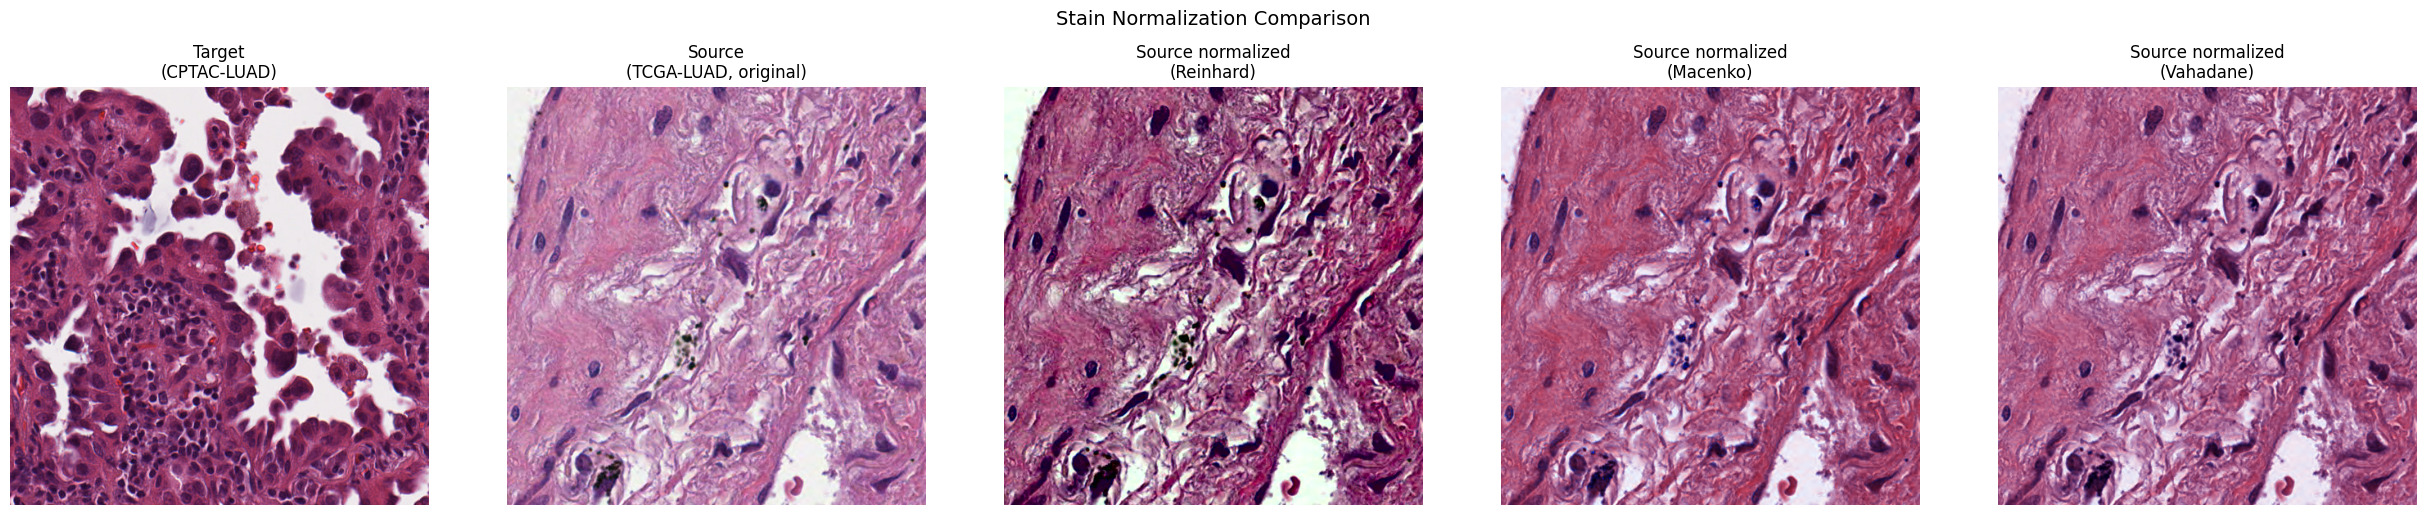

In [ ]:
# Compare all results
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].imshow(patch_target)
axes[0].set_title("Target\n(CPTAC-LUAD)", fontsize=12)
axes[0].axis('off')

axes[1].imshow(patch_source)
axes[1].set_title("Source\n(TCGA-LUAD, original)", fontsize=12)
axes[1].axis('off')

for i, (name, result) in enumerate(normalized.items()):
    axes[i + 2].imshow(result)
    axes[i + 2].set_title(f"Source normalized\n({name})", fontsize=12)
    axes[i + 2].axis('off')

plt.suptitle("Stain Normalization Comparison", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Normalize Multiple Patches

Let's extract several patches from the source slide and normalize them all to show that the method works consistently across different tissue regions.

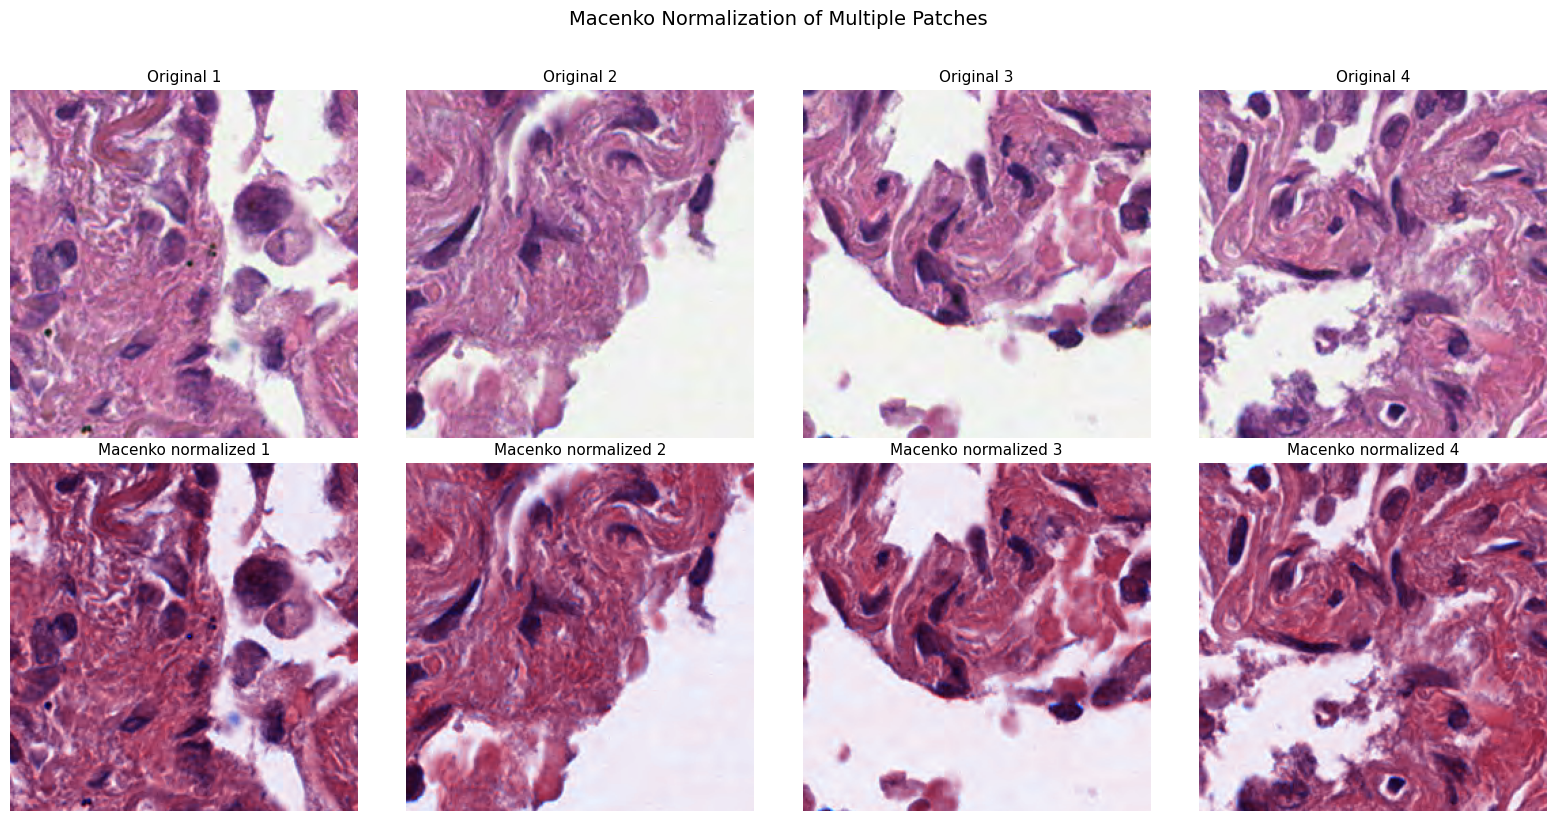

In [ ]:
# Extract multiple patches at different positions
source_reader = readers['tcga_luad']
thumb = source_reader.slide_thumbnail(resolution=1.25, units="power")
gray = np.mean(thumb, axis=2)
tissue_mask = gray < 200
tissue_coords = np.argwhere(tissue_mask)

slide_w, slide_h = source_reader.info.slide_dimensions

# Sample 4 random tissue locations
np.random.seed(42)
n_patches = 4
sample_indices = np.random.choice(len(tissue_coords), n_patches, replace=False)

source_patches = []
for idx in sample_indices:
    ty, tx = tissue_coords[idx]
    bx = int(tx * slide_w / thumb.shape[1])
    by = int(ty * slide_h / thumb.shape[0])
    loc = (max(0, bx - 128), max(0, by - 128))
    patch = source_reader.read_rect(
        location=loc, size=(256, 256),
        resolution=source_reader.info.objective_power,
        units="power",
        coord_space="resolution",
    )
    source_patches.append(patch)

# Normalize with Macenko
macenko = MacenkoNormalizer()
macenko.fit(patch_target)

fig, axes = plt.subplots(2, n_patches, figsize=(4 * n_patches, 8))
for i, patch in enumerate(source_patches):
    axes[0][i].imshow(patch)
    axes[0][i].set_title(f"Original {i+1}", fontsize=11)
    axes[0][i].axis('off')

    norm_patch = macenko.transform(patch.copy())
    axes[1][i].imshow(norm_patch)
    axes[1][i].set_title(f"Macenko normalized {i+1}", fontsize=11)
    axes[1][i].axis('off')

plt.suptitle("Macenko Normalization of Multiple Patches", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Color Distribution Comparison

Let's visualize how normalization shifts the color distributions of the source to match the target.

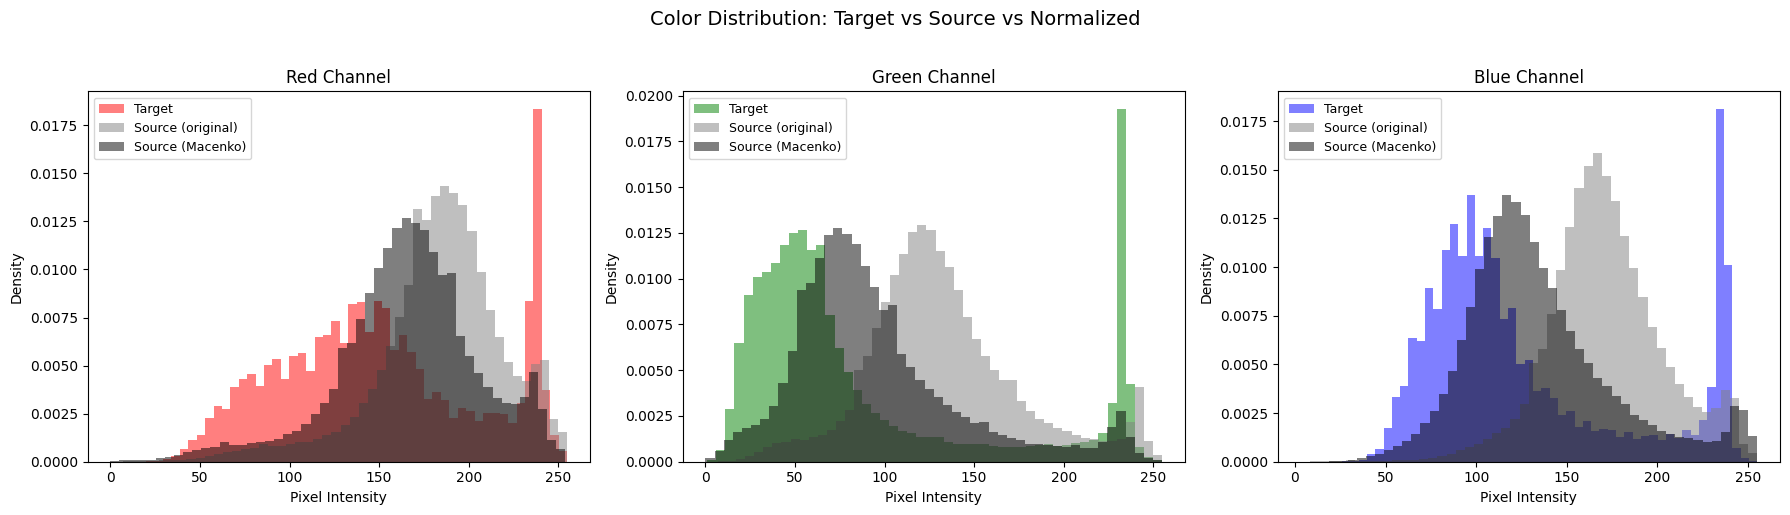

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for i, (color, name) in enumerate(zip(colors, channel_names)):
    axes[i].hist(patch_target[:, :, i].ravel(), bins=50, alpha=0.5,
                 color=color, label='Target', density=True)
    axes[i].hist(patch_source[:, :, i].ravel(), bins=50, alpha=0.5,
                 color='gray', label='Source (original)', density=True, linestyle='--')
    axes[i].hist(normalized['Macenko'][:, :, i].ravel(), bins=50, alpha=0.5,
                 color='black', label='Source (Macenko)', density=True)
    axes[i].set_title(f"{name} Channel", fontsize=12)
    axes[i].legend(fontsize=9)
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Density")

plt.suptitle("Color Distribution: Target vs Source vs Normalized", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we learned how to:

- Identify **stain variation** between slides from different IDC collections/scanners
- Apply three TIAToolbox normalization methods: **Reinhard**, **Macenko**, and **Vahadane**
- **Fit** a normalizer to a target image and **transform** source images to match
- Compare normalization results both visually and through color distributions

**When to use which method:**
- **Reinhard**: Fastest, good for quick preprocessing when speed matters
- **Macenko**: Good balance of speed and quality, widely used in practice
- **Vahadane**: Best structure preservation, recommended when quality is critical

**Next:** [Notebook 04](04_patch_classification.ipynb) demonstrates tissue patch classification using TIAToolbox's pretrained models.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5